Training started...
Processing dataset: 228_elusage.tsv
{'regression__precompute': True, 'regression__positive': False, 'regression__selection': 'random', 'regression__fit_intercept': True, 'feature_selection__k': 1, 'regression__l1_ratio': 0.5}
R-square score: 0.57


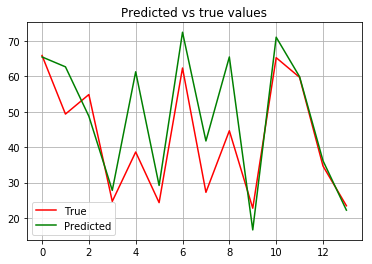

---------------------


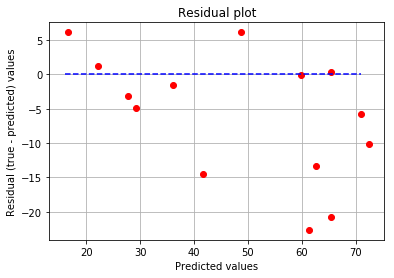

Finished dataset: 228_elusage.tsv
------------------------------------------------------------
Processing dataset: 485_analcatdata_vehicle.tsv
{'regression__precompute': False, 'regression__positive': False, 'regression__selection': 'random', 'regression__fit_intercept': True, 'feature_selection__k': 2, 'regression__l1_ratio': 1.0}
R-square score: 0.54


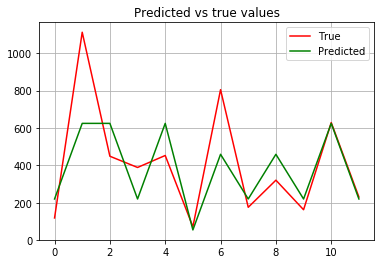

---------------------


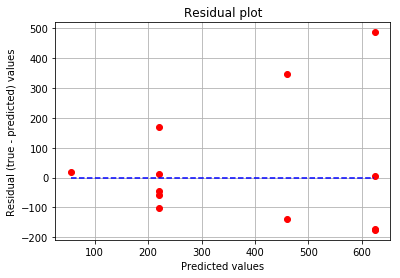

Finished dataset: 485_analcatdata_vehicle.tsv
------------------------------------------------------------
Processing dataset: 523_analcatdata_neavote.tsv
{'regression__precompute': True, 'regression__positive': False, 'regression__selection': 'random', 'regression__fit_intercept': True, 'feature_selection__k': 1, 'regression__l1_ratio': 1.0}
R-square score: 0.94


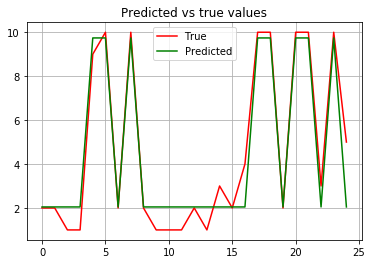

---------------------


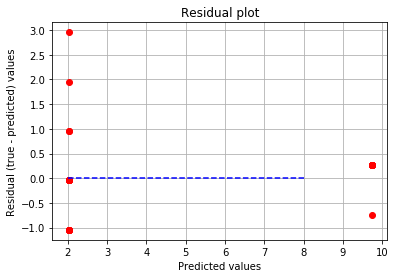

Finished dataset: 523_analcatdata_neavote.tsv
------------------------------------------------------------
Processing dataset: 663_rabe_266.tsv
{'regression__precompute': True, 'regression__positive': False, 'regression__selection': 'random', 'regression__fit_intercept': True, 'feature_selection__k': 2, 'regression__l1_ratio': 1.0}
R-square score: 0.95


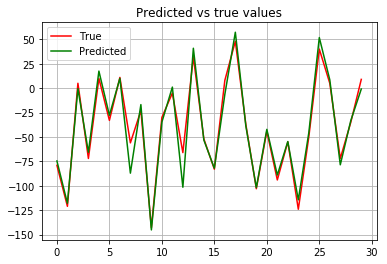

---------------------


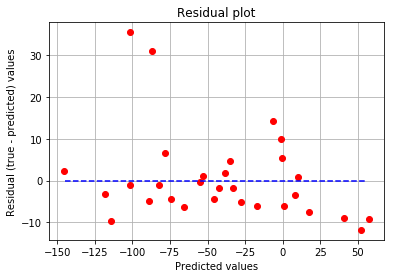

Finished dataset: 663_rabe_266.tsv
------------------------------------------------------------
Processing dataset: 687_sleuth_ex1605.tsv
{'regression__precompute': True, 'regression__positive': False, 'regression__selection': 'random', 'regression__fit_intercept': True, 'feature_selection__k': 3, 'regression__l1_ratio': 1.0}
R-square score: 0.70


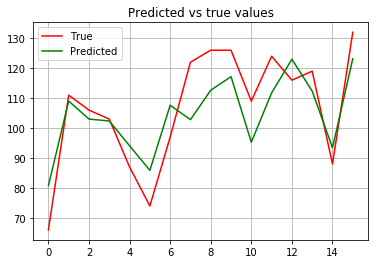

---------------------


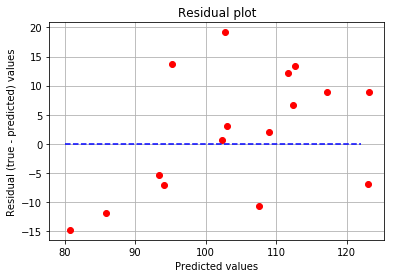

Finished dataset: 687_sleuth_ex1605.tsv
------------------------------------------------------------
Training finished
('Mean R2 square: \n', 0.7418614698951321)
Total time taken: 318 seconds


In [1]:
import sys
import time
import pandas as pd
from sklearn import model_selection
from sklearn import linear_model, metrics, cluster
from matplotlib import pyplot as plt
import scipy
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.feature_selection import *
from sklearn.model_selection import GridSearchCV, KFold
import warnings


warnings.filterwarnings('ignore')


%matplotlib inline
start_time = time.time()
datasets = ["228_elusage.tsv", "485_analcatdata_vehicle.tsv", "523_analcatdata_neavote.tsv", \
            '663_rabe_266.tsv', '687_sleuth_ex1605.tsv']


regressor = Pipeline([
  ('preprocessing', preprocessing.RobustScaler()),
  ('feature_selection', SelectKBest(f_regression)),
  ('regression', linear_model.ElasticNetCV())
])


ard_parameters = [{ \
    'feature_selection__k': [1, 2, 3, 4], \
    'regression__l1_ratio': [0.0, 0.0001, 0.01, 0.1, 0.5, 1.0], \
    'regression__fit_intercept': [True, False], \
    'regression__precompute': [True, False], \
    'regression__positive': [True, False], \
    'regression__selection': ['random', 'cyclic'] \
}]

print('Training started...')
dataset_accuracies = list()
r2_scores = list()
for d_set in datasets:
    print("Processing dataset: %s" % d_set)
    data_path = "data/" + d_set
    df = pd.read_csv(data_path, sep="\t")
    label = df["target"].copy()
    data = df.drop("target", axis=1)
    optimized_regressor = GridSearchCV(regressor, ard_parameters, \
                                       cv=KFold(n_splits=3, shuffle=True, random_state=3111696), \
                                       error_score=0, scoring='r2')
    optimized_regressor.fit(data, label)
    best_regressor = optimized_regressor.best_estimator_
    best_result = optimized_regressor.cv_results_
    print(optimized_regressor.best_params_)
    best_score = optimized_regressor.best_score_
    r2_scores.append(best_score)
    print("Best score: ", best_score)
    print("Finished dataset: %s" % d_set)
    print("------------------------------------------------------------")

print('Training finished')
print("Mean R2 square: \n", np.mean(r2_scores))
end_time = time.time()
print('Total time taken: %d seconds' % int(end_time - start_time))

